# Clover Health: Take Home Exercise
## Behrad Bagheri

In this document we go over the data provided, find most common and indicative medications for each of the disease in the dataset and finally will use logistic regression and neural networks to predict the chance of a patient being diagnosed for a certain disease given their medication history.

### Outline
This document is outlined as follows:

    - Initial data loading
    - Minor data curation
    - Looking into the data: extract common and indicative medications
    - Data structure preparation for modelling, feature extraction
    - Data preprocessing (normalization, feature selection
    - Models:
        - Logistic Regression
        - Neural Network
    - Summary
    - Notes on postgres and large dataset
    


In [442]:
import pandas as pd
import numpy as np
import seaborn as sns

import psycopg2

from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn import feature_selection

from matplotlib import pyplot

## Loading Data
A short simple method for importing the data is to use Pandas read_csv function to load. Although we might want to load the data from Postgress SQL database as well. 

Here we have Method1 for loading data directly from CSV:

In [443]:
conditions = pd.read_csv('meps_conditions.csv')
meds = pd.read_csv('meps_meds.csv');
meps_base = pd.read_csv('meps_base_data.csv');

### Using Postgres 
The alternate method is to connect to the postgres database using psycopg2 library. Here is how I would do it:

The database is setup on port 8228 (not the default port, so we have to set port in our connection string as well), it is named Clover and the user is default postgres user.

** The code below is an example of how we can use Postgres, to make sure we can function on this NoteBook that data was loaded from CSV / The final section of the document discusses about loading from loarger sets ** 

In [444]:
## THIS SECTION MIGHT NOT WORK AS YOU MIGHT NOT HAVE POSTGRES SETUP 

conn = psycopg2.connect("dbname=Clover user=postgres port=8228")
query = "select * from meps_base_data";
meps_base = pd.read_sql_query(query,conn)
print "Meps Base Data loaded from Postgres, DataFrame size is " + str(meps_base.shape)

Meps Base Data loaded from Postgres, DataFrame size is (61489, 17)


## Data Curation
Now that we have the data loaded. We can perform minor curations on the data to prepare it for analysis.

First step, as string data is available in the data set, we convert string columns to category for better/easier visualizations if needed.

In [445]:
#Function to convert string columns to category. 
def Strings2Cat(df):
    ## We go through each column of DataFrame and if it is of type object, we convert it to category. 
    for col in df.columns:
        if  df[col].dtype == 'object':
            df[col] = df[col].astype('category')
    return df

The next step is to use our recently created function. 
    - In meps_base, it converts 'sex','race','married' and diagnosis columns to categorical
    - In conditions dataset, it converts icd9ConditionCode column to categorical
    - In meds dataset it converts rxName, rxQuantity and rxForm to categorical
    
Before we apply the function to meds dataset we have to make a minor modification. 


In [446]:
# Convert string types to categorical 
meps_base = Strings2Cat(meps_base)
conditions = Strings2Cat(conditions)

In [447]:
# For further usage, we group the conditions dataset by 'id' and count the occurunce of visits.
conditions_grouped = conditions.groupby('id').agg({'numberOfInpatientEvents':['size','sum']}).reset_index()
conditions_grouped.columns=['id','visits','events']
display(conditions_grouped.head(5))

,id,visits,events
0,10007101,5,0
1,10007102,2,0
2,10007103,1,0
3,10007104,1,0
4,10008101,2,0


Let's understand the meds dataset a little bit better. 

In [448]:
print meds.columns.tolist()

['Unnamed: 0', 'id', 'rxStartMonth', 'rxStartYear', 'rxName', 'rxNDC', 'rxQuantity', 'rxForm']


There are two major indicators of medication type in this dataset.
    
1- **rxNDC**: A unique medication identifier. But there is an important caviat to this code. Based on [This](https://www.findacode.com/ndc/ndc-national-drug-codes.html) reference, the code is created based on 
        
        a. Labeler code
        b. Product code: identifies a specific strength, dosage form, and formulation of a drug
        c. Package code: identifies package sizes and types
     
Although this code is very sueful when we want to do a comprehensive analysis on what forms of medication are mo effective and/or medication from which pharma company is performing better, but it does not help our purpose on determining the general type of medications per disease. 

For these reasons we are not going to use this code throughout the analysis.
    
2- **rxName**: The medication name which includes the overall type of the medication (our target) and a suffix that might be a subgroup of the medication or dosage or etc. 

As we are looking for the most commonly used medications for each disease we have to make sure we can combine as much medication as possible based on their rxName. One solution is to just use the first portion of their name in the meds dataset 

    

In [449]:
# Split Medication names based on space character.
# The output if a two column data frame where the first column is the text before first space
# and second part is the rest of the text

tempRxCategory = meds["rxName"].str.strip().str.upper().str.split(' ',1,expand=True)
# We rename the columns for better usage
tempRxCategory.columns = ['rxName','rxRest']

#Replacements = [{"LEVOTHYROXIN":"LEVOTHYROXINE","LEVOTHROXIN":"LEVOTHYROXINE"}]

tempRxCategory.loc[(tempRxCategory["rxName"] == "LEVOTHYROXIN")] = "LEVOTHYROXINE"
tempRxCategory.loc[(tempRxCategory["rxName"] == "LEVOTHROXIN")] = "LEVOTHYROXINE"
# We can rename the original rxName in the meds dataset to preserve it
meds.rename(columns={'rxName':'rxCompleteName'}, inplace=True)

# Then we concatenate the original meds data with rxName column of tempRXCategory 
meds = pd.concat([meds,tempRxCategory['rxName']],axis=1)

# Now the meds dataset is ready to curate string columns 
meds = Strings2Cat(meds)

display(meds.head(5))

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxCompleteName,rxNDC,rxQuantity,rxForm,rxName
0,1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR,AMOXICILLIN
1,2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL,OTIC
2,3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR,NASAL
3,4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR,NASAL
4,5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP,DIPHENHYDRAM


One more step in preprocessing is to add a new column in base dataset that indicates how many diseases each patient is diagnosed with. This would help us find patients with only one disease easier. 

In [450]:
# Select diagnosis columns
diseasNames = meps_base.columns[7:]
# Create a matrix of boolean values based on if patient is diagnosed with that specific disease
healthStatus_conditons = meps_base[diseasNames] == 'Yes'
# Sum the values per row to count the number of diseases each patient has. 
healthStatus_indicator = np.sum(healthStatus_conditons, axis = 1)
# Assign the count value to a new column in meps_base
meps_base['noDiagnosed'] = healthStatus_indicator

## Analysis
Now we dive into the analysis of the data. 
Our target is to find which medications are more common and indicative for each disease. Therefore we want to look into the history of medications prescribed for patients that are diagnosed with our target disease. 

**Important point**: We know that patients diagnosed with more than one disease might receive different medications to avoid medication conflicts. Therefore if we want to find the most indicative medications for each disease it is better to look into those that are diagnosed only with our target disease. Then we can compare the results with those who are diagnosed with other diseases as well to find most common medication. 


**Processing**
We want to create features that would be useful for building our prediction model as well as determining important medications. Here are the key factors we try to accomplish:
    - Age Brackets: This bracket would help to distinguish certain type of medications that are commonly prescribed due to the age of the patients (For example Lipitor) 
    Age brackets are defined as [Chil-Teenager/Youn Adult/Middle Age/Elderly]
    - NoPrescriptions: The number of times that a certain medication is prescribed for the patient. 
    - Freq: A ratio value. It demonstrates the ratio of total number of times that a certain med was prescribed for a patient over the number of visits patient had in conditions dataset. 
    - Average Dosage: Average quantity of the medication prescribed to the patient. 
    


In [451]:
def patientDataProcessor(selected_patients, meps_base,conditions_grouped):
    
    # Age brackets for granular look into the medication prescription 
    ageBrackets = [0,18,45,65,120]
    
    # Variable to hold number of patients 
    noPatients = selected_patients.shape[0]
    
    # Now we query our meds dataset for history of these patients. 
    medicationsUsed = meds.loc[meds['id'].isin(selected_patients['id'])]
    
    # Now we group by patient and medication and count number of times it was prescribed
    medicationsUsed_perpatient = medicationsUsed.groupby(['id', 'rxName']).agg({'rxQuantity':['size','mean']}).reset_index()
    medicationsUsed_perpatient.columns = ['id', 'rxName','noPrescription','avgDose']
    
    # Having number of prescriptions alone is not useful, so we calculate a metric for how often it was prescribed based on the number of visits the patient had to the clinic.
    # For that, we need visits value from conditions dataset. So we merge meds with visits value from conditions
    medicationsUsed_perpatient_merged = pd.merge(medicationsUsed_perpatient, conditions_grouped,on='id',how='outer')
    
    # now we calculate Freq = #Presictions/#Visits
    medicationsUsed_perpatient_merged['Freq'] = medicationsUsed_perpatient_merged['noPrescription']/medicationsUsed_perpatient_merged['visits']
    
    
    # Overall Disease obversvations #
    
    # Now we group by medication type only (summarizing all patients) 
    # We calculate how many patients the medication was prescribed to, and avg frequency of it.
    overall_medicationUsage = medicationsUsed_perpatient_merged.groupby(['rxName']).agg({'noPrescription':'size','Freq':'mean'}).reset_index()
    
    # We need to rename the column for clarification
    overall_medicationUsage.rename(columns={'noPrescription' : 'No_Patients_Prescribed'},inplace=True)
    
    # Adding Count and Percentage columns. Count is total patients we had for the disease and Percentage is the percentage of those who received the medication
    overall_medicationUsage["Total_Patient_Count"] = noPatients
    overall_medicationUsage["Percentage"] = overall_medicationUsage["No_Patients_Prescribed"]/ noPatients
    
    # Now we calculate a new metric, Contribution value. 
    # The metric considers the frequency and popularity of medication 
    # by combining Percentage (how variant the use of the medication was) and Freq (how often it was prescribed)
    overall_medicationUsage["Contrib"] = overall_medicationUsage["Percentage"] * overall_medicationUsage["Freq"]
    
    # We sort values to have highest contributing medications on top. 
    overall_medicationUsage = overall_medicationUsage.sort_values('Contrib',ascending = False)
    
    
    # Additional Per Patient Information #
    
    # Including demographic information
    patientsAgeAndSex = selected_patients[['id','sex','age']]
    
    # Create Age brackets 
    ageGroup = pd.DataFrame(pd.cut(patientsAgeAndSex["age"],ageBrackets)).rename(columns={"age":"ageGroup"})
    patientsAgeAndSex = pd.concat([patientsAgeAndSex,ageGroup],axis=1)

    # Combine Patient demographic information with medication
    medicationUsed_perPatient_withPatientInfo = pd.merge(patientsAgeAndSex, 
                                                         medicationsUsed_perpatient_merged, 
                                                         on='id',
                                                         how='inner')
    
    # Now we return values. 
    return overall_medicationUsage, medicationUsed_perPatient_withPatientInfo

## Common and Indicative Meds
Now that we have our function ready, we can generate list of medications that are prescribed to the patients. For indicative medications, we can look into the **Contrib** feature that we just generated, but for common medications we just look into the **Percentage** of the time that the medication was prescribed. 

**NOTE**: In the snippet below we mainly query our meds dataset based on the patients who only have the target disease and we ignore those who have other diseases. This is because if we do not so, we will mostly find very common medications such as *LISINOPRIL* which is being used for high blood pressure. 

In [452]:
# Place holders
indicative_meds = pd.DataFrame()
common_meds = pd.DataFrame()
general_meds = pd.DataFrame()

noTopMeds2Return = 3

# Iterating through diseases
for selectedDisease in diseasNames:
    # Select Patients only Diagnosed with the selected disease
    patients_HavingOnlyTheSelectedDisease = meps_base[(meps_base[selectedDisease] == 'Yes') & (meps_base['noDiagnosed'] == 1)]
    
    # Run our function to get disease overview (we skip patient based output #2)
    output,_ = patientDataProcessor(patients_HavingOnlyTheSelectedDisease, meps_base, conditions_grouped)
    
    # Outputs are sorted based on Contrib value by default. We select top n meds (we define n in noTopMeds2Return)
    diseaseInfo_indicative = output.head(noTopMeds2Return).reset_index(drop=True)
    # Add metadata
    diseaseInfo_indicative["disease"] = selectedDisease
    # Append to the complete list
    indicative_meds = pd.concat([indicative_meds, diseaseInfo_indicative])
    
    # For common meds
    # We do the same process for this data except we use Percentage to select our top n 
    diseaseInfo_common = output.sort_values('Percentage',ascending=False).head(noTopMeds2Return).reset_index(drop=True)
    # Add metadata
    diseaseInfo_common["disease"] = selectedDisease
    # Append to the complete list
    common_meds = pd.concat([common_meds, diseaseInfo_common])
    
    # This is to demonstrate if we do not filter to only those who have target disease, we get bad results. 
    # Here we are calculating the common meds using patients who have our target disease only or with at least one more. 
    patients_HavingWithSelectedDiseaseAndOthers = meps_base[(meps_base[selectedDisease] == 'Yes')]
    output,_ = patientDataProcessor(patients_HavingWithSelectedDiseaseAndOthers, meps_base, conditions_grouped)
    diseaseInfo_general = output.sort_values('Percentage',ascending=False).head(noTopMeds2Return).reset_index(drop=True)
    diseaseInfo_general["disease"] = selectedDisease
    general_meds = pd.concat([general_meds, diseaseInfo_general])


Now we can look into our common medications. The list below shows our common medications per disease. The list is sorted based on disease and the based on decreasing Percentage value. So Those with Index = 0 are the most common medications for their respective diease. Subsequently, Index 1 and 2 are the 2nd and 3rd most common meds.

In [453]:
display(common_meds)

,rxName,Freq,No_Patients_Prescribed,Total_Patient_Count,Percentage,Contrib,disease
0,LISINOPRIL,1.253781,1126,6676,0.168664,0.211468,highbpdiagnosed
1,AMLODIPINE,1.187809,763,6676,0.114290,0.135755,highbpdiagnosed
2,SIMVASTATIN,0.924423,746,6676,0.111744,0.103298,highbpdiagnosed
0,METFORMIN,1.510930,423,833,0.507803,0.767255,diabetesdiagnosed
1,ONETOUCH,0.521404,157,833,0.188475,0.098272,diabetesdiagnosed
2,LISINOPRIL,0.929096,145,833,0.174070,0.161727,diabetesdiagnosed
0,SIMVASTATIN,1.228069,13,80,0.162500,0.199561,chddiagnosed
1,METOPROLOL,0.596394,13,80,0.162500,0.096914,chddiagnosed
2,IBUPROFEN,0.472661,7,80,0.087500,0.041358,chddiagnosed
0,METOPROLOL,1.332468,8,41,0.195122,0.259994,midiagnosed


We can also look into it as a figure. It helps us find any similarities between common meds between disease.

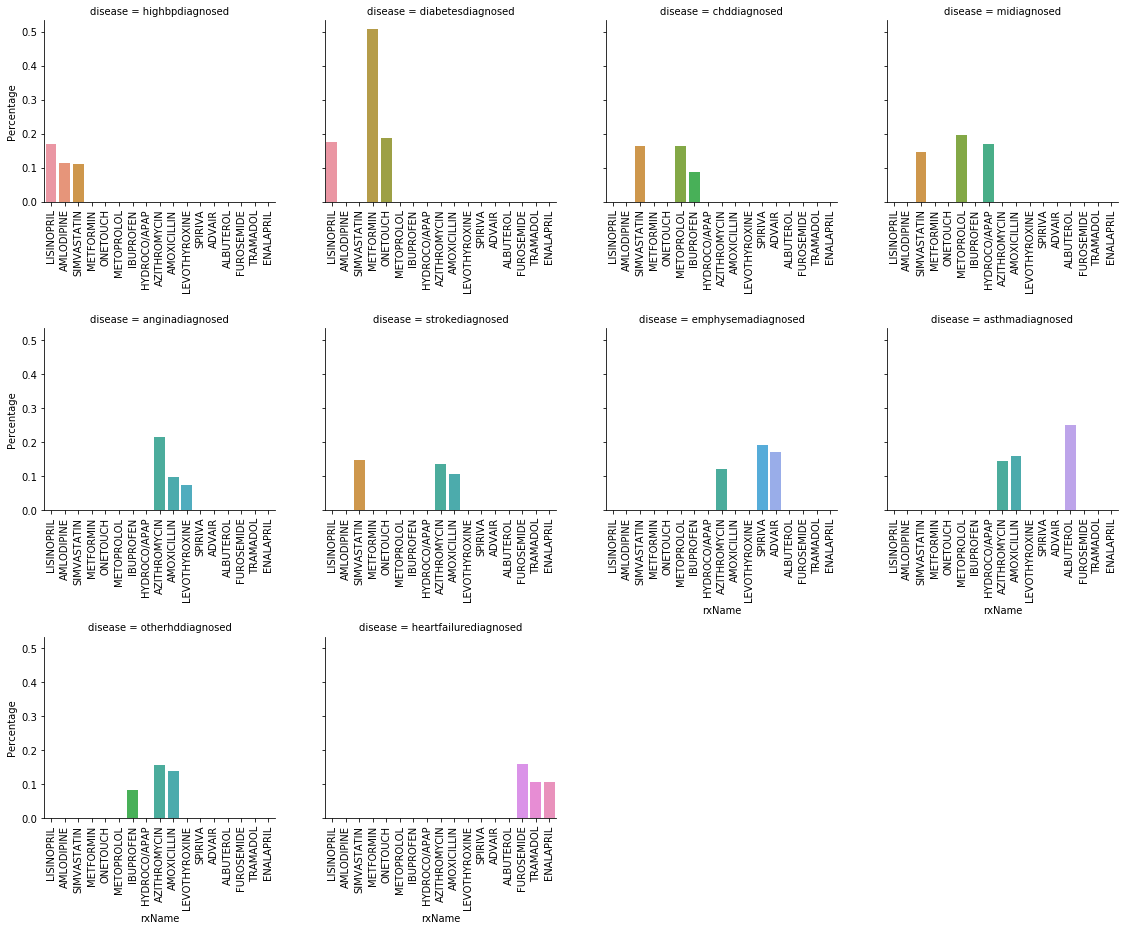

In [454]:
p=sns.factorplot(x='rxName',y='Percentage',col="disease",col_wrap=4, data = common_meds,kind="bar")

for ax in p.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=90)
plt.subplots_adjust(hspace=0.7)

plt.show(p)

The list below shows our indicative medications per disease. Similar to Common meds, Index 0 represents the most indicative med based on **Contrib** feature. We can also look into their graphs afterwards. 

In [455]:
display(indicative_meds)

,rxName,Freq,No_Patients_Prescribed,Total_Patient_Count,Percentage,Contrib,disease
0,LISINOPRIL,1.253781,1126,6676,0.168664,0.211468,highbpdiagnosed
1,AMLODIPINE,1.187809,763,6676,0.114290,0.135755,highbpdiagnosed
2,ATENOLOL,1.418237,504,6676,0.075494,0.107069,highbpdiagnosed
0,METFORMIN,1.510930,423,833,0.507803,0.767255,diabetesdiagnosed
1,GLIPIZIDE,1.716315,116,833,0.139256,0.239007,diabetesdiagnosed
2,LISINOPRIL,0.929096,145,833,0.174070,0.161727,diabetesdiagnosed
0,SIMVASTATIN,1.228069,13,80,0.162500,0.199561,chddiagnosed
1,WARFARIN,2.172408,5,80,0.062500,0.135776,chddiagnosed
2,ATENOLOL,1.412283,6,80,0.075000,0.105921,chddiagnosed
0,METOPROLOL,1.332468,8,41,0.195122,0.259994,midiagnosed


Figures below show the most indicative medications per disease. The significant difference between **METFORMIN** and other medications for Diabete shows that this medication is solely a very good representer of the disease. 
The case is imilar for **LEVOTHYROXINE** in Angina although it has a lower contrib value. We can expect better classification/prediction results for these two diseases.  

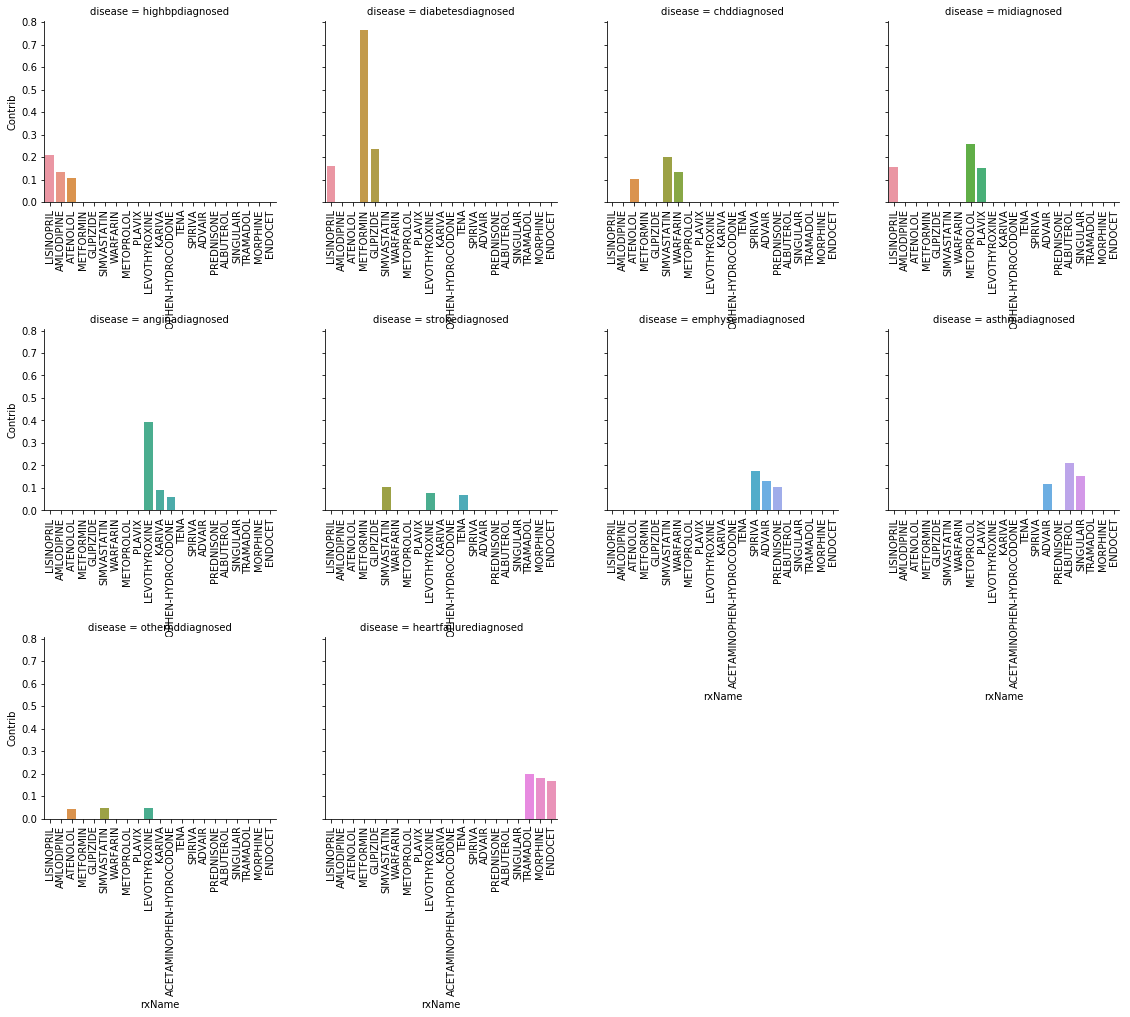

In [456]:
p=sns.factorplot(x='rxName',y='Contrib',col="disease",col_wrap=4, data = indicative_meds,kind="bar")

for ax in p.axes:
    plt.setp(ax.get_xticklabels(), visible=True, rotation=90)
plt.subplots_adjust(hspace=0.7)

plt.show(p)

Now let's look at the other variable we generated, General Meds, as well and compare it with Common Meds. Figures below are quite descriptive on this matter.
The first figure shows the caviate we described earlier about using the data from the patients who have other medications as well. As it is obvious, common medications selected in the first figure do not quite represent the desired disease.  

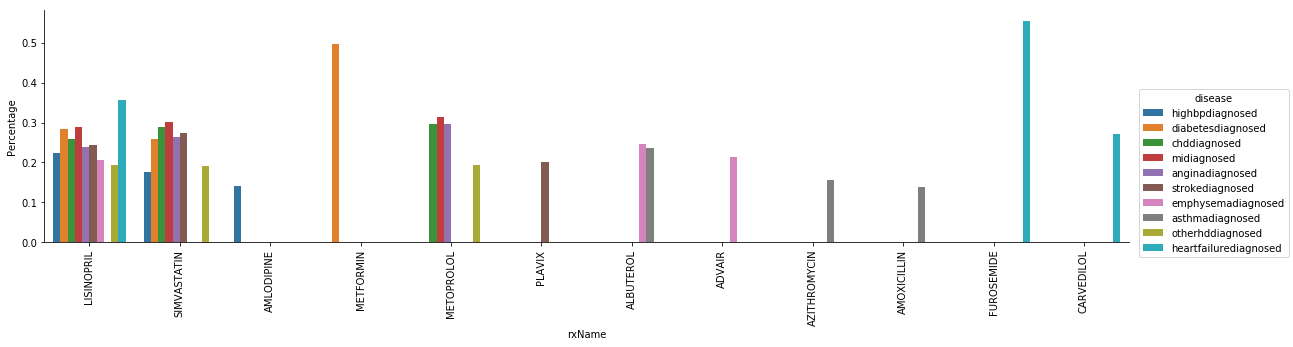

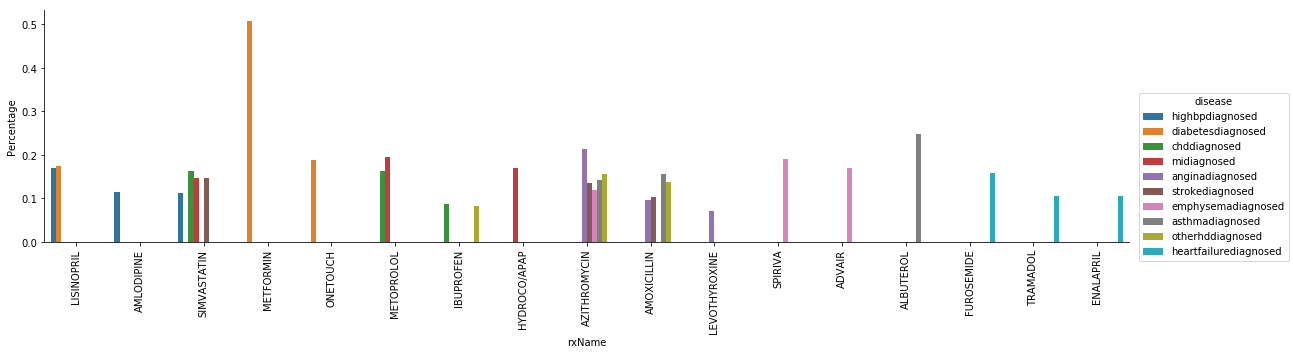

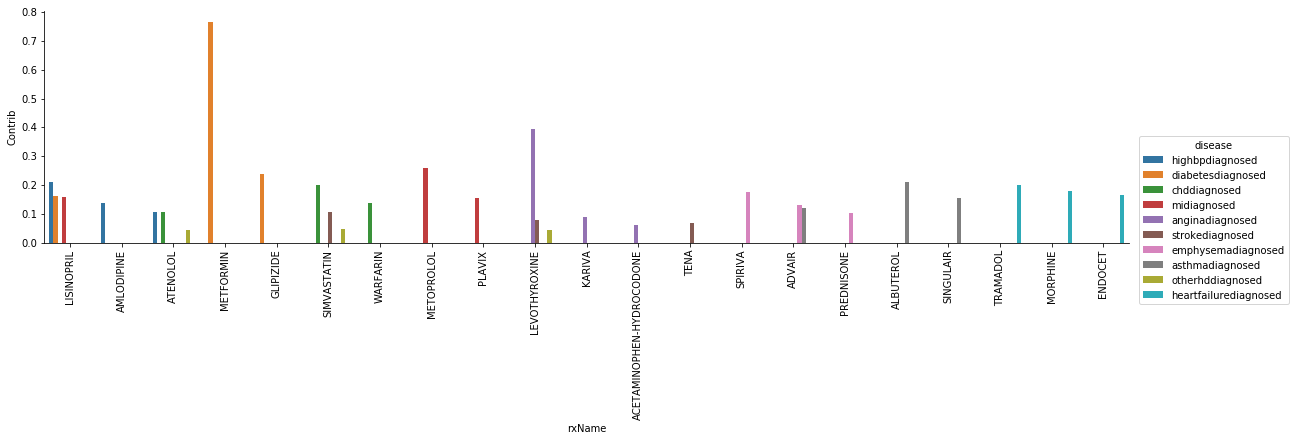

In [457]:
p1 = sns.factorplot(x='rxName',y='Percentage',hue='disease',data = general_meds,kind='bar',size=4,aspect=4)
p1.set_xticklabels(rotation=90)
p1.set_titles('General Meds')

p2 = sns.factorplot(x='rxName',y='Percentage',hue='disease',data = common_meds,kind='bar',size=4,aspect=4)
p2.set_xticklabels(rotation=90)
p2.set_titles('Indicative Meds')


p3 = sns.factorplot(x='rxName',y='Contrib',hue='disease',data = indicative_meds,kind='bar',size=4,aspect=4)
p3.set_xticklabels(rotation=90)
p3.set_titles('Indicative Meds')



plt.show([p1,p2])

## Data Preparation For Models
Now that we looked into common and indicative medications for each disease, we can start preparing the data for predictive models. 
Inputs to the function below are patientInfo (which is generated by our previous function, *patientDataProcessor* and indicative/common medications for the target disease.
The function performs the following tasks:

    1- Filters Patient medication history to our selected medications (indicative meds) 
    2- Turn Medication values from Row items to columns (pivot) once based on their Freq value once based on average dose
    3- Expands categorial values (Sex and AgeGroup) so separate columns represent either of their unique values
    4- Remove ID column (as we do not need it anymore) 

After all the above operations, the function returns a data frame which is ready for being used in the analysis. 
    

In [458]:
def prepareModelData(patientsInfo,topMeds):
    #First we filter the list of medication for patients, to the top medications that we just selected
    selectedMeds = patientsInfo.loc[patientsInfo['rxName'].isin(topMeds['rxName'])]
    
    # Now we pivot the data so medication name is a column and its respective average freq or average dose is the respective value
    selectedMedsPivotFreq = selectedMeds.pivot(index='id',columns='rxName',values='Freq').reset_index()
    selectedMedsPivotDose = selectedMeds.pivot(index='id',columns='rxName',values='avgDose').reset_index()
    
    # Now we turn our categorical values in patient profile (sex and age group) into separate columns
    patientsInfoUnfolded = pd.concat([patientsInfo[['id','visits']],patientsInfo['sex'].str.get_dummies(),patientsInfo['ageGroup'].str.get_dummies()],axis = 1)
    
    # Now we combine unfolded patient info with pivot tables we just created
    preparedPatientInfoTable = pd.merge(patientsInfoUnfolded,selectedMedsPivotFreq,on='id',how='inner')
    preparedPatientInfoTable = pd.merge(preparedPatientInfoTable,selectedMedsPivotDose,on='id',how='inner')
    
    # We don't need to hav patient ID anymore
    del preparedPatientInfoTable['id']
    
    # The data only contains Male/Female (If it contained additional genders this line of code was wrong)
    # So we can get rid of one of the genders as the other one surves the purpose
    del preparedPatientInfoTable['Male']
    preparedPatientInfoTable.rename(columns={'Female':'Gender'},inplace=True)
    
    preparedPatientInfoTable.reset_index(drop=True,inplace=True)
    # Many of the rows in pivot table have NA because the medication was not present. It logically makes sense to replace the values with 0 
    preparedPatientInfoTable.fillna(0,inplace=True)
    
    return preparedPatientInfoTable

## Predict Disease From Medication
### Default Disease = Diabette
Using the function above, we can start doing the prediction. The prediction method presented here is general for all the disease although it has been tested and enhanced for Diabettes, it should be able to predict others (with lower accuracy). 


The code below selects our target disease. By Default the notebook shows outputs for Diabettes but you can simple change the target disease bellow and run the rest of snippets to get results for other diseases. 

In [459]:
# Select Target Disease
selectedDisease = diseasNames[1] ## <--- Change index between 0 and 9 and run all the snippets bellow to get results for other disease.

Now, based on our selected disease, we select patients for our train and test sets. 
First we query our base dataset for patients with and without our target disease. 

In [460]:
# Now we select patients.
# We are still separating patients with only our target disease and those with at least one other
# so we can use the diseaseInfo output of the processor function (although we could refer to our Common-Indicative matirces)
# But here we leverage more medications than only 2 or 3 that we selected there. 

patients_HavingOnlyTheSelectedDisease = meps_base[(meps_base[selectedDisease] == 'Yes') & (meps_base['noDiagnosed'] == 1)]
patients_HavingThisDiseaseOrOthers = meps_base[(meps_base[selectedDisease] == 'Yes') & (meps_base['noDiagnosed'] > 1)]
patients_notHavingThisDisease = meps_base[(meps_base[selectedDisease] == 'No')]

# Now we process the data we queries. 
diseaseInfo, patientsInfo =  patientDataProcessor(patients_HavingOnlyTheSelectedDisease, meps_base,conditions_grouped)
_, patientsInfo_HavingThisDiseaseOrOthers =  patientDataProcessor(patients_HavingThisDiseaseOrOthers, meps_base,conditions_grouped)
_, patientsInfo_notHavingThisDisease =  patientDataProcessor(patients_notHavingThisDisease, meps_base,conditions_grouped)


Now we use our diseaseInfo data to infere even more common/indicative medications. 

In [461]:
#Common meds based on Percentage
commonMeds = diseaseInfo.sort_values('Percentage',ascending = False).head(15)
#Indicative Meds based on Contrib
indicativeMeds = diseaseInfo.sort_values('Contrib',ascending = False).head(15)

# Now we combine them together and remove duplicates. 
topMeds = pd.concat([commonMeds,indicativeMeds ])
topMeds = topMeds.set_index('rxName')
topMeds.drop_duplicates(inplace=True)
topMeds.reset_index(inplace=True)

# Here is the med we selected 
print(topMeds['rxName'])

0        METFORMIN
1         ONETOUCH
2       LISINOPRIL
3      SIMVASTATIN
4        GLIPIZIDE
5            ACTOS
6        GLYBURIDE
7          NOVOLIN
8          HUMULIN
9          INSULIN
10             ONE
11       TRUETRACK
12          LANTUS
13    AZITHROMYCIN
14         LIPITOR
15     GLIMEPIRIDE
16         NOVOLOG
17         HUMALOG
Name: rxName, dtype: object


Now that we know which meds are important for us, we call our *prepareModelData* function to generate prediction ready data. 

In the next section, we also prepare our desired outputs (0: not diagnosed, 1: diagnosed). 


In [462]:
#group1-3x values will be prepared inputs for the model. (they are not yet normalized)
group1_x = prepareModelData(patientsInfo,topMeds)
group2_x = prepareModelData(patientsInfo_HavingThisDiseaseOrOthers,topMeds)
group3_x = prepareModelData(patientsInfo_notHavingThisDisease,topMeds)

# group1-3y are our desired outputs from the model. (0 - not diagnosed, 1 - diagnosed)
# note that group1 and 2 are having value of 1 because both are those who have our target disease
# group3 are those who do not have our target disease so it is 0
group1_y = np.ones(group1_x.shape[0])
group2_y = np.ones(group2_x.shape[0]) 
group3_y = np.zeros(group3_x.shape[0])

# Let's see how the inputs look like. 
# {rxName}_x = Contrib Value, {rxName}_y = AvgDose Value
display(group1_x.head(5))

,visits,Gender,"(0, 18]","(18, 45]","(45, 65]","(65, 120]",ACTOS_x,AZITHROMYCIN_x,GLIMEPIRIDE_x,GLIPIZIDE_x,...,LANTUS_y,LIPITOR_y,LISINOPRIL_y,METFORMIN_y,NOVOLIN_y,NOVOLOG_y,ONE_y,ONETOUCH_y,SIMVASTATIN_y,TRUETRACK_y
0,5,0,0,0,1,0,1.2,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,0,0,0,1,0,1.2,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0,0,0,1,0,1.2,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,0,0,0,1,0,1.2,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0,0,1,0,1.2,0.0,0.0,0.0,...,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train-Test set separation
Now we have to separate our train-test sets. We can use SKLearn functions for it. Here we separete (70-30 for our general trainin)
Later we validate generalization of the models using cross validation. 


In [463]:
# First we contactenate all Inputs and Outputs. 
X = pd.concat([group1_x,group2_x, group3_x])
X.fillna(0,inplace=True)
Y= np.concatenate([group1_y,group2_y, group3_y])

print "Inputs Shape: " + str(X.shape) + ", Outputs Shape: " + str(Y.shape)


# Now we separate Train and Test Sets. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0, stratify=Y)
print "Train Data Shape: " + str(X_train.shape) + ", Test Data Shape: " + str(X_test.shape)

Inputs Shape: (112171, 42), Outputs Shape: (112171,)
Train Data Shape: (78519, 42), Test Data Shape: (33652, 42)


(array([ 45701.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  32818.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

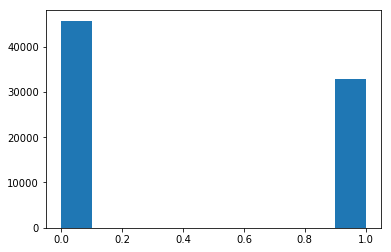

In [464]:
plt.hist(Y_train)

One important point about the data is the fact that for some diseases, the data is extremely biased. We can reduce the effect the bias on our model by trying to balance the Trainin dataset (training only) The section below looks into the data and if it is too biased, it removes some of the not-diagnosed values. 

(It had to be modifed to remove some of the diagnosed values as well (for cases like highbloodpressure) but it does not do that in current form)

In [465]:
if (np.mean(Y_train) < 0.4):
    balancingFactor = (1 - np.mean(Y_train))/2 
    i = np.nonzero(Y_train - 1)[0]
    ix = np.random.choice(len(i), np.floor(balancingFactor * len(i)), replace=False)

    X_train1=X_train.reset_index(drop=True).drop(i[ix])
    Y_train1 = np.delete(Y_train,i[ix])
    
    print "Imbalance improved from %0.2f to %0.2f" % (np.mean(Y_train),np.mean(Y_train1))
else:
    X_train1= X_train
    Y_train1= Y_train

### Data Normalization and Feature Selection
Now that we have our train-test sets separated. We should normalize the data and select proper features. 
For both tasks we use our training data only and then apply it to test dataset. 
We normalize the data using MaxAbsScaler which bounds data between [-1,1] and select features usinga univariate feature selection. Although as we prepared our data very well the we do not need to remove a large portion of the data (proved by trial tests) 


In [466]:
# Data Normalization
#Initialize normalizer
dataScaler = preprocessing.MaxAbsScaler()
#Normalize train data
X_train_normalized = dataScaler.fit_transform(X_train1)
#normalize test data
X_test_normalized = dataScaler.transform(X_test)

In [476]:
# Feature Selection 
#initialize feature selector
fs = feature_selection.SelectPercentile(feature_selection.chi2,percentile=75)
_ = fs.fit_transform(X_train_normalized + 1,Y_train1) #Values should not be negative so we add 1 (this is the reason we do not retain the results)
X_train_n_fs = fs.transform(X_train_normalized) 
X_test_n_fs = fs.transform(X_test_normalized)

print "Number of Features Reduced from %i to %i" % (X_train_normalized.shape[1],X_train_n_fs.shape[1])

Number of Features Reduced from 42 to 31


## Logistic Regression

The first method to try here is Logistic regression. We try to predict the probability of a person being diagnosed by our target disease. 

**Output 91.26% for Diabettes**. Using the processing method described above, Logistic regression could assess 91.17% of the cases. Although the value is high but it is not perfect as it might mis-diagnose a patient. 

The detailed scores below shows that the model slightly tends to fail to find presence of the disease in patients. 

In [478]:
model = LogisticRegression()
model = model.fit(X_train_n_fs, Y_train1)
predicted = model.predict(X_test_n_fs)


print "Predicion Results for "  + selectedDisease + "\n"
print "Prediction Accuracy: %0.2f%%" % (roc_auc_score(predicted,Y_test) *100)
print "Model Metrics:"
print metrics.classification_report(Y_test, predicted)
print "Confusion Matrix:"
print str(confusion_matrix(Y_test,predicted))


Predicion Results for diabetesdiagnosed

Prediction Accuracy: 91.26%
Model Metrics:
             precision    recall  f1-score   support

        0.0       0.89      0.96      0.92     19587
        1.0       0.94      0.83      0.88     14065

avg / total       0.91      0.91      0.91     33652

Confusion Matrix:
[[18774   813]
 [ 2322 11743]]


### Cross Validation For Logistic Regression
Now we can use cross validation to make sure our model is generalized enough. Here we use 5 fold cross validation. 

**Output: Average 90.62% ± 1.04 for diabette**

In [479]:
nFolds = 5

#We need to use normalized data and select features before supplying X to Cross Validation
X_n = dataScaler.transform(X)
X_n_fs = fs.transform(X_n)

scores=cross_val_score(model,X_n_fs,Y,cv=5,scoring='f1_weighted')
scores=scores*100

print "Logistic Regression: %i folds cross validation Accuracy: %0.2f%% ± %0.2f" %(nFolds,np.mean(scores), np.std(scores))

Logistic Regression: 5 folds cross validation Accuracy: 90.62% ± 1.04


## Neural Network
To get better results we can try a more complex classification method. Here we train a multi-layer neural network to determine if our patients are diagnosed or not. 

The network has several hidden layers to properly transform the data from our meds/patient status info to probability of presence of the disease. Here we use Adam solver with Relu activation functions to form the network (in my tests adam outperformed sgd, and Relu outperformed Tanh). 

** Output: 94.01% for diabette**


In [480]:
nnModel = MLPClassifier(solver='adam', alpha=1e-4, hidden_layer_sizes=(30,20,15,5), max_iter=500,random_state=1, activation='relu')
nnModel.fit(X_train_n_fs,Y_train1)
nnPredict = nnModel.predict(X_test_n_fs)

print "Predicion Results for "  + selectedDisease + "\n"
print "Prediction Accuracy: %0.2f%%" % (roc_auc_score(nnPredict,Y_test) *100)
print "Model Metrics:"
print metrics.classification_report(Y_test, nnPredict)
print "Confusion Matrix:"
print str(confusion_matrix(Y_test,nnPredict))

Predicion Results for diabetesdiagnosed

Prediction Accuracy: 94.01%
Model Metrics:
             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95     19587
        1.0       0.94      0.91      0.93     14065

avg / total       0.94      0.94      0.94     33652

Confusion Matrix:
[[18815   772]
 [ 1264 12801]]


### Cross Validation For Neural Netowrk
similar to LR, we want to make sure our model is generalized and would be useful in a prodution set. Here we perform a 5 fold cross validation to show its reliability. 

** Output : 90.97% ± 0.42 for diabette **

In [481]:
nFolds = 5
scores=cross_val_score(nnModel,X_n_fs,Y,cv=5,scoring='f1_weighted')
scores=scores*100

print "Neural Networks: %i folds cross validation Accuracy: %0.2f%% ± %0.2f" %(nFolds,np.mean(scores), np.std(scores))

Neural Networks: 5 folds cross validation Accuracy: 90.97% ± 0.42


## Summary

In this document we briefly looked into the medication, hospitalization and demographic data from patients. We realized the common medications for each of the diseases we had within our dataset and then we used two machine leanring methods, namely logistic regression and neural networks for modeling the possibility of presence of a disease given history of medication. 


## Notes on Postgres and Large Datasets
Instead of loading the data from CSV fiels, we could query a database throughout the entire code (as I mentioned early in the code). But for flexibility of the code,it has not integrated (only demonstrated in one snippet)

For the section that we added the number of diseases each person is diagnosed with, we could use database triggers in base data table so that the value gets calculated automatically everytime a new item is added to the table

We perform several merge functions (joint). All these could have been joint queries from the databse. 

Most of the data curation and preparing parts of this work could turn into iteration tasks. For example calculating Contrib, Freq and other values could be iterated on a per patient basis so the amount of data loaded into memory is  minimized. (or better to say, we could optimize between the scale of data being queried and number of interaction with SQL). 